In [1]:
from fastai.text import *
import pandas as pd

## Loading the data

In [2]:
path = Path('/home/sarvagya/Desktop/fellowship/')

In [3]:
df = pd.read_csv(path/'Tweets.csv')
print(df.head())

             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnar

### Distribution of data into training and validation set

In [4]:
train_df, valid_df = df.loc[:12000,:], df.loc[12000:,:]

## Data training
The two columns that we need for training are the sentiment column and the text column. 

#### Sentiment Column:
This column is the classification of the tweet into "positive", "negative" and "neutral"

#### Test
This column contains the tweet and we'll need this for processing the words and use them for classification


### Creating models:
As suggested in the video by Jeremy Howard, we'll need two models for the classification:
1) Language model
2) Text model

And we'll use `TextLMDataBunch` and `TextClasDataBunch` predefined methods of `FastAI` for this purpose

In [6]:
data_lm = TextLMDataBunch.from_df(path, train_df, valid_df, text_cols=10, bs=32)
data_clas = TextClasDataBunch.from_df(path, train_df, valid_df, text_cols=10, label_cols=1, bs=32)

### Method:

As Jeremy Howard mentioned in the video, the library uses different techniques of replacing some words with unique represtation so that the text in the required format for tranfer learning. 

Some of them include:

`xxbos`: Starting of a sentence

`xxmaj`: Next word starts with capital letter

In [6]:
data_lm.show_batch()

idx,text
0,"about it xxbos @virginamerica seriously would pay $ 30 a flight for seats that did n't have this playing . \n it 's really the only bad thing about flying xxup va xxbos @virginamerica yes , nearly every time i fly xxup vx this “ xxunk xxunk ” wo n’t go away :) xxbos @virginamerica xxmaj really missed a prime opportunity for xxmaj men xxmaj without xxmaj hats xxunk"
1,"you guys were starting those flights at the end of the month ! xxmaj guess i ’m still road tripping on xxmaj feb 27 … xxbos @virginamerica thanks for that . xxmaj been needing a way to make those xxmaj austin trips from xxup dca , and now you 've come through ! xxbos @virginamerica announced xxmaj new xxmaj route to xxmaj austin w / fares from $ 39 /"
2,xxmaj delhi call centers . xxmaj poor xxmaj united staff spread thin and stressed . xxmaj you name it . xxbos @united xxmaj yes . xxmaj does n't make that mistake any less absurd . xxmaj does n't change the fact that i 'm very xxunk missing my luggage tonight . xxbos @united i 'm constantly having challenges with upgrades & & charges . xxmaj in order to prevent xxup
3,"xxbos @united , and now while waiting for new pilot the door on plane xxup broke . why am i global services status on an airline that 's unsafe ? xxup stunning xxbos @united xxmaj how do i get reimbursed for hotel and taxis for the xxmaj cancelled xxmaj flightation ? xxbos @united xxmaj awesome flight crew on xxup xxunk , re the plane , the xxmaj xxunk period called"
4,is 2:30 hrs delayed so far b / c of xxmaj late xxmaj flight crew . xxmaj now we are literally waiting while they have dinner xxunk . to honest gate agent . xxbos @united many people on xxmaj xxunk are going to miss connections due to long wait time in xxup sfo tarmac . xxmaj seriously u ca n't find an empty gate ? xxbos @united xxmaj you 're


In [7]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
"xxbos @usairways yes , i am as well . * * xxup five * * xxup hours xxup on xxup hold , xxup folks . xxmaj can you xxup please tell me if this is typical ? ! xxmaj trying to be understanding here .",negative
"xxbos @united xxmaj right now at xxmaj xxunk xxmaj air in xxmaj san xxmaj pedro , # xxmaj belize . xxmaj line out the door . xxmaj all due to xxunk & & xxunk hacks http : / / t.co / xxunk ”",negative
xxbos @southwestair so u xxmaj cancelled xxmaj flight our flight to xxup phx bc of xxup sdf weather but flights 2 the xxup xxunk from xxup sdf are still going on ? ! xxup wtf ? http : / / t.co / xxunk,negative
xxbos @united xxmaj outbound 2 bags 70 lbs bags xxmaj returning home 1 bag 50 lbs . xxmaj what is your logic ? xxmaj and xxup why ? xxmaj am i writing to a xxmaj machine ? xxmaj human xxup help required,negative


## Training a learning model

The training pipeline is similar to the suggested one inthe video. We'll use the method `language_model_learner` to start training the model on the dataset with pre-trained weights.The model is an LSTM network that has been trained on WikiText-2. 

In [8]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3)

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


### Plotting the different learning rates and get an approximate one

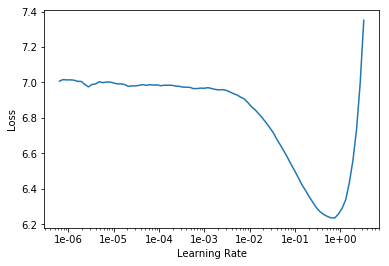

In [10]:
learn.recorder.plot()

This shows the training on 1 epoch using learning rate as 10^-2

In [11]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.588647,4.230567,0.232277,00:10


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


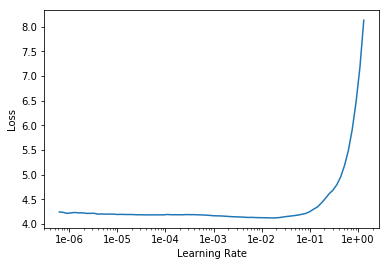

In [12]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.066679,4.085023,0.252068,00:12
1,3.915313,3.941308,0.266771,00:12
2,3.755960,3.843711,0.272351,00:12
3,3.561793,3.792901,0.278155,00:12
4,3.366153,3.787436,0.280699,00:12
5,3.181973,3.792159,0.280804,00:12
6,2.989702,3.822484,0.280417,00:12
7,2.874581,3.849319,0.278527,00:12
8,2.792377,3.861765,0.278929,00:12
9,2.760313,3.866188,0.278854,00:12


## Saving the encoder and training the decoder for classification

In LSTM models, we have an encoder and a decoder to help us classify text. Since text is nothing but sequential data, we need to train both the encoder and decoder for this purpose. 

In the first task, we'll use an encoder to create a vector of inputs. This can alsoe be used to generate text as shown below. 

The decoder acts as the output for the encoder vector. We first train it and then use it to get the final prediction of the input text

In [14]:
# make predictions
TEXT = "I liked "
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

# save encoder
learn.save_encoder('twitter-sentiment-enc')

I liked  with you ! What 's the point of the call even though the " call center " was accepted ? It 's all about being on hold for 3 hours ! xxbos @usairways @americanair any info on the
I liked  , “ You Are the Best ” ” Thank you FOR your follow up . # Stuck in Chicago with a loyal family . Better to hear it ! xxbos @jetblue


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


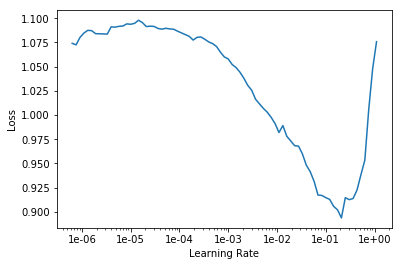

In [7]:
# create model and load in encoder
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.3)
learn.load_encoder('twitter-sentiment-enc')

# find and plot learning rate
learn.lr_find()
learn.recorder.plot()

## Training the decoder

For training the classification model, we’ll start off by training the decoder, and then we’ll unfreeze one layer after another

In [11]:
learn.fit_one_cycle(1, 1e-2)

# unfreeze one layer group and train another epoch
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.675979,0.484690,0.817424,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.594712,0.435106,0.828030,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.550747,0.404381,0.849621,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.447294,0.392748,0.849242,00:17


Now that our model is trained completly (noth encoder and decoder), we will test them on a tweet

In [12]:
learn.predict("it was an amazing flight")

(Category positive, tensor(2), tensor([1.1540e-03, 4.8647e-05, 9.9880e-01]))

In [14]:
learn.predict("it was a horrible flight")

(Category negative, tensor(0), tensor([9.9651e-01, 2.6979e-03, 7.9560e-04]))

#### Let's try with spelling and grammatical mitsakes

(btw, I know)

In [16]:
learn.predict("it was an disgstng flight")

(Category neutral, tensor(1), tensor([0.2965, 0.5868, 0.1167]))